In [1]:
import pandas as pd
import sqlalchemy as sa

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

import numpy as np

import json

C:\Users\christopher.sampson\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
engine = sa.create_engine(open("SQL_queries/engine.txt", 'r').read())

In [3]:
# Inter arrival time

with open("data/iats.json", 'r') as fin:
    iat_dict = json.load(fin)

iat_dict = {k:(np.array(v[0]), np.array(v[1])) for k,v in iat_dict.items()}

# Wait list

with engine.connect() as conn:
    tno_wait_list_df = pd.read_sql(open("SQL_queries\\tno_wait_list.sql").read(), con=conn.connection) # This list is up-to-date

# Proecdure durations

with open("data/surgery_durations.json", 'r') as fin:
    theatre_dur_dict = json.load(fin)

theatre_dur_dict = {k:(np.array(v[0]), np.array(v[1])) for k,v in theatre_dur_dict.items()}

# Remaining LoS

with open("data/remaining_los.json", 'r') as fin:
    remaining_los = json.load(fin)

remaining_los = (np.array(remaining_los[0]), np.array(remaining_los[1]))

# LoS

with open("data/los.json", 'r') as fin:
    los_dict = json.load(fin)

los_dict = {k:(np.array(v[0]), np.array(v[1])) for k,v in los_dict.items()}


with engine.connect() as conn:
    tno_theatre_slots_df = pd.read_sql(open("SQL_queries\\tno_theatre_slots_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date

tno_theatre_slots_df["SchDur"] = pd.to_numeric(tno_theatre_slots_df["SchDur"])
tno_theatre_slots_df["em_el_dc"] = tno_theatre_slots_df["em_el_dc"].fillna("EMERG")

def generate_schedule():
    min_date = tno_theatre_slots_df["SchSurgeryDate"].min()
    em_el_dc_mapping = {"DCASE":"Daycase", "EMERG":"Emergency", "ELECT":"Elective", None:"Emergency"}   

    schedule = []

    for date_room, theatre_slot_df in tno_theatre_slots_df.groupby(["SchSurgeryDate", "SchOperatingRoom"]):
        hours_remaining = theatre_slot_df["SchDur"].sum() / 60
        patient_type = em_el_dc_mapping[theatre_slot_df["em_el_dc"].mode()[0]]
        hour = ((date_room[0] - min_date) + pd.Timedelta(f"{theatre_slot_df['SchSurgeryTime'].min()}:00")) / pd.Timedelta(hours=1)
        schedule.append((hour, patient_type, hours_remaining, hours_remaining, []))

    return pd.DataFrame(schedule.copy(), columns=["hour", "patient_type", "hours_total", "hours_remaining", "patients"]).sort_values(by="hour")

sim_day_1 = pd.to_datetime("01/03/25", dayfirst=True)

with engine.connect() as conn:
    theatre_df = pd.read_sql(open("SQL_queries\Theatre draft 2.1_cs_edit.sql").read(), con=conn.connection)

def create_schedule(theatre_df):

    theatre_df["SchDur"] = pd.to_numeric(theatre_df["SchDur"])

    theatre_df = theatre_df[["SchOperatingRoom", "SchSurgeryDate", "SchSurgeryDateTime", "SchDur", "LoS", "em_el_dc", "ReferralDate"]]

    theatre_df["LoS"] = theatre_df["LoS"].fillna(theatre_df["LoS"].max())
    theatre_df["ReferralDate"] = theatre_df["ReferralDate"].fillna(theatre_df["SchSurgeryDate"])

    hours_remaining = 0
    schedule = []
    
    em_el_dc_mapping = {"DCASE":"Daycase", "EMERG":"Emergency", "ELECT":"Elective", None:"Emergency"}

    for schdateroom, schdf in theatre_df.groupby(["SchOperatingRoom", "SchSurgeryDate"]):

        sorted_df = schdf.sort_values(by=["SchSurgeryDateTime"])

        hour = int(round((sorted_df["SchSurgeryDateTime"].iloc[0] - sim_day_1) / pd.Timedelta(hours=1)))
        hours_total = (sorted_df["SchSurgeryDateTime"].iloc[-1] + pd.Timedelta(minutes=sorted_df["SchDur"].iloc[-1]) - sorted_df["SchSurgeryDateTime"].iloc[0]) / pd.Timedelta(hours=1)
        patients = []

        patient_type = em_el_dc_mapping[schdf["em_el_dc"].mode()[0]]

        schedule.append([hour, patient_type, hours_total, hours_total, patients])


    schedule = pd.DataFrame(schedule, columns = ["hour", "patient_type", "hours_total", "hours_remaining", "patients"]).sort_values(by="hour")
    schedule = schedule[schedule["hour"] <= 14*24]

    return schedule

# Initial emergency patients

emerg_wait_list = pd.DataFrame(np.random.randint(0, 48, size=52), columns=["hours_waited"])
emerg_wait_list = emerg_wait_list.sort_values(by="hours_waited", ascending=False)

with engine.connect() as conn:
    init_occupancy_df = pd.read_sql(open("SQL_queries\\tno_inpatient_initial_occupancy_dynamic.sql").read(), con=conn.connection)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_8168\597848824.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_wait_list_df = pd.read_sql(open("SQL_queries\\tno_wait_list.sql").read(), con=conn.connection) # This list is up-to-date
C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_8168\597848824.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_theatre_slots_df = pd.read_sql(open("SQL_queries\\tno_theatre_slots_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date
C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_8168\597848824.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database

In [4]:
# Setting up the experiement

import itertools
from surgical_sim import Patient
from sim_tools.distributions import GroupedContinuousEmpirical, DiscreteEmpirical


SEED = 42

EMERGENCY_MEAN_IAT = 10
EMERGENCY_SURGICAL_DURATION = 3
EMERGENCY_MEAN_RECOVERY_TIME = 60

ELECTIVE_MEAN_IAT = 16
ELECTIVE_SURGICAL_DURATION = 2
ELECTIVE_MEAN_RECOVERY_TIME = 48

RUN_LENGTH = 480
NUM_BEDS = 100
NUM_CC_BEDS = 16

DAILY = 24
WEEKLY = 7 * DAILY

INITIAL_NUMBER_OF_ELECTIVE = 3
INITIAL_NUMBER_OF_EMERGENCY = 1

MAX_EMERGENCY_WAIT = 48


class Experiment:
    def __init__(
        self,
        iat_dict,
        theatre_dur_dict,
        los_dict,
        remaining_los,
        seed=SEED,
        initial_number_of_elective=INITIAL_NUMBER_OF_ELECTIVE,
        initial_number_of_emergency=INITIAL_NUMBER_OF_EMERGENCY,
        max_emergency_wait=MAX_EMERGENCY_WAIT,
    ):
        self.patients = []

        self.initial_number_of_elective = initial_number_of_elective
        self.initial_number_of_emergency = initial_number_of_emergency

        seeds = np.random.SeedSequence(seed).spawn(10)

        self.emergency_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["EMERG"][1][:-1],
            upper_bounds = iat_dict["EMERG"][1][1:],
            freq = iat_dict["EMERG"][0],
            random_seed = seeds[0]
        )

        self.elective_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["ELECT"][1][:-1],
            upper_bounds = iat_dict["ELECT"][1][1:],
            freq = iat_dict["ELECT"][0],
            random_seed = seeds[1]
        )

        self.dcase_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["DCASE"][1][:-1],
            upper_bounds = iat_dict["DCASE"][1][1:],
            freq = iat_dict["DCASE"][0],
            random_seed = seeds[2]
        )

        mask = np.where(theatre_dur_dict["EMERG"][0] > 0)
        self.emergency_surgical_duration_dist = DiscreteEmpirical(
            ((theatre_dur_dict["EMERG"][1][:-1] + theatre_dur_dict["EMERG"][1][1:]) /2)[mask],
            theatre_dur_dict["EMERG"][0][mask],
            random_seed = seeds[3]
        )

        mask = np.where(theatre_dur_dict["ELECT"][0] > 0)
        self.elective_surgical_duration_dist = DiscreteEmpirical(
            ((theatre_dur_dict["ELECT"][1][:-1] + theatre_dur_dict["ELECT"][1][1:]) /2)[mask],
            theatre_dur_dict["ELECT"][0][mask],
            random_seed = seeds[4]
        )

        mask = np.where(theatre_dur_dict["DCASE"][0] > 0)
        self.dcase_surgical_duration_dist = DiscreteEmpirical(
            ((theatre_dur_dict["DCASE"][1][:-1] + theatre_dur_dict["DCASE"][1][1:]) /2)[mask],
            theatre_dur_dict["DCASE"][0][mask],
            random_seed = seeds[5]
        )

        self.emergency_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["EMERG"][1][:-1],
            upper_bounds = los_dict["EMERG"][1][1:],
            freq = los_dict["EMERG"][0],
            random_seed = seeds[6]
        )

        self.elective_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["ELECT"][1][:-1],
            upper_bounds = los_dict["ELECT"][1][1:],
            freq = los_dict["ELECT"][0],
            random_seed = seeds[7]
        )

        self.dcase_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["DCASE"][1][:-1],
            upper_bounds = los_dict["DCASE"][1][1:],
            freq = los_dict["DCASE"][0],
            random_seed = seeds[8]
        )

        self.remaining_los_dist = GroupedContinuousEmpirical(
            lower_bounds = remaining_los[1][:-1],
            upper_bounds = remaining_los[1][1:],
            freq = remaining_los[0],
            random_seed = seeds[9]
        )

        self.max_emergency_wait = max_emergency_wait


class PatientGenerator:
    def __init__(self, arrival_dist, surgical_duration_dist, recovery_time_dist, patient_prefix):
        self.arrival_dist = arrival_dist
        self.surgical_duration_dist = surgical_duration_dist
        self.recovery_time_dist = recovery_time_dist
        self.prefix = patient_prefix
        
    def generate_patient(self, env, experiment, schedule):
        for patient_count in itertools.count(start=1):
            inter_arrival_time = self.arrival_dist.sample()

            yield env.timeout(inter_arrival_time)

            p = Patient(
                f"{self.prefix}{patient_count}",
                arrival_time=env.now,
                surgery_duration=self.surgical_duration_dist.sample(),
                recovery_time=self.recovery_time_dist.sample(),
            )
            experiment.patients.append(p)

            logging.info(f"{env.now:.2f}: {p.id} referral arrives.")

            schedule.schedule_patients([p], env.now)

    def initial_generate_patient(self, env, experiment, schedule, wait_list):
        patient_count = -1
        for _, row in wait_list.iterrows():
            p = Patient(
                f"{self.prefix}{patient_count}", 
                arrival_time=-row["hours_waited"], 
                surgery_duration=self.surgical_duration_dist.sample(), 
                recovery_time=self.recovery_time_dist.sample()
            )

            experiment.patients.append(p)
            logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

            schedule.schedule_patients([p], env.now)
            

            patient_count -= 1


In [5]:
# Loading the ward

initial_num_occupied_beds = len(init_occupancy_df)

def bed_preload(env, beds, remaining_los, metrics):
    with beds.request() as bed_req:
        yield bed_req
        metrics["bed_event"].append((env.now, 1))
        yield env.timeout(remaining_los)
        metrics["bed_event"].append((env.now, -1))

def initialise_ward_random(env, beds, initial_num_occupied_beds, experiment, metrics):
    for time_remaining in experiment.remaining_los_dist.sample(initial_num_occupied_beds):
        env.process(bed_preload(env, beds, time_remaining, metrics))

### Reducing number of beds

In [6]:
import logging
from surgical_sim import setup_logger, daily_planning, scheduler, Schedule, setup_logger
import simpy
from collections import defaultdict

from joblib import Parallel, delayed

# TODO: Fix this...
env = simpy.Environment()
logger = setup_logger(env)

def single_run(run_id=1, seed=42, max_emergency_wait=480):
    s = Schedule([])

    schedule_df = create_schedule(theatre_df)

    s.processed_schedule = schedule_df
    s._Schedule__schedule = {
        hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
        for hour, data in schedule_df.groupby("hour")
    }
    print(type(s.processed_schedule.loc[:, "patients"].values[0]))

    experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, remaining_los, seed=seed, max_emergency_wait=max_emergency_wait)

    emergency_patient_generator = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency")
    elective_patient_generator = PatientGenerator(experiment.elective_arrival_dist, experiment.elective_surgical_duration_dist, experiment.elective_recovery_time_dist, "Elective")
    dcase_patient_generator = PatientGenerator(experiment.dcase_arrival_dist, experiment.dcase_surgical_duration_dist, experiment.dcase_recovery_time_dist, "Daycase")

    metrics = defaultdict(lambda : [])
    env = simpy.Environment()

    logger = setup_logger(env, logging.INFO)

    beds = simpy.Resource(env, capacity=NUM_BEDS)
    cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

    initialise_ward_random(env, beds, len(init_occupancy_df),experiment, metrics)

    elective_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "Inpatient"'))
    dcase_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "DCASE"'))
    emergency_patient_generator.initial_generate_patient(env, experiment, s, emerg_wait_list) 

    env.process(emergency_patient_generator.generate_patient(env, experiment, s))
    env.process(elective_patient_generator.generate_patient(env, experiment, s))
    env.process(dcase_patient_generator.generate_patient(env, experiment, s))
    env.process(daily_planning(env, beds, s, experiment))
    env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

    env.run(until=14*24)

    metrics["patients"] = experiment.patients
    metrics["scheduled"] = s.processed_schedule
    metrics["seed"] = seed

    metrics["cancellation_percent"] = (len([p for p in metrics["patients"] if p.cancellations != []]) / len([p for p in metrics["patients"] if p.surgical_time is not None])) * 100
    metrics["emergency_surgery"] = sum([p.surgery_duration for p in metrics["patients"] if p.surgical_time is not None and "Emergency" in p.id])
    metrics["emlective_surgery"] = sum([p.surgery_duration for p in metrics["patients"] if p.surgical_time is not None and "Elective" in p.id])
    metrics["daycase_surgery"] = sum([p.surgery_duration for p in metrics["patients"] if p.surgical_time is not None and "Daycase" in p.id])

    return metrics


def parallel_run(num_cores=-1, num_runs=1, seed=42, max_emergency_wait=480):
    seed_spawn = np.random.SeedSequence(seed).spawn(num_runs)
    results = Parallel(n_jobs=num_cores)(
        delayed(single_run)(i, seed_spawn[i].generate_state(1)[0], max_emergency_wait) for i in range(num_runs)
    )
    return results

# res = parallel_run(num_runs=100)

In [9]:
beds_ensemble = []
surgeries_ensemble = []

for i, r in enumerate(res):
    r["bed_event"].sort(key=lambda e: (e[0], e[1]))
    bed_events = np.array(r["bed_event"])

    beds = bed_events[:, 1].cumsum()
    df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied beds {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    beds_ensemble.append(df_beds.drop("Change", axis=1))


    r["surgical_event"].sort(key=lambda e: (e[0], e[1]))

    surgical_event = np.array(r["surgical_event"])
    surgeries = surgical_event[:, 1].cumsum()
    df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied theatres {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    surgeries_ensemble.append(df_surgery.drop("Change", axis=1))


NameError: name 'res' is not defined

TypeError: reduce() of empty iterable with no initial value

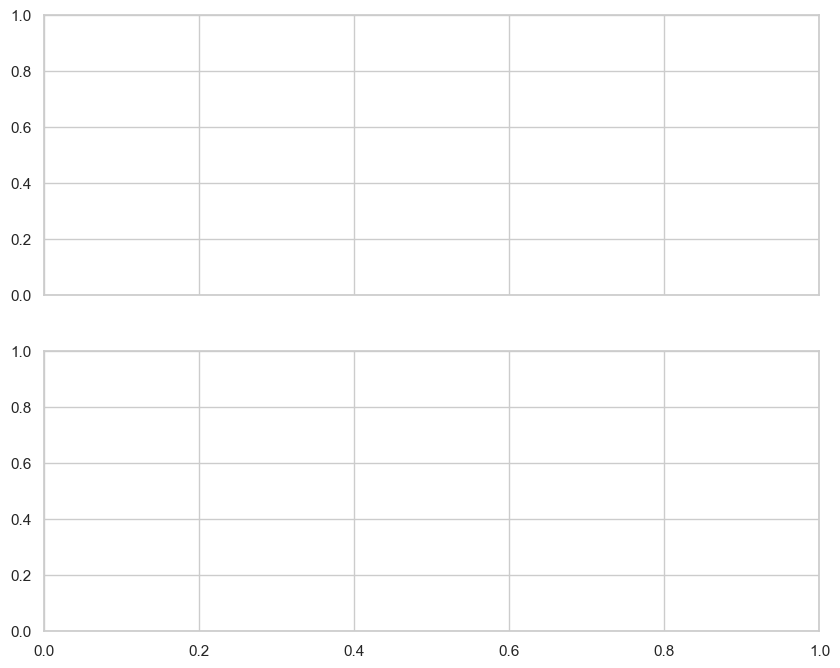

In [10]:
from functools import reduce

fig, ax = plt.subplots(2,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)


merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)

sns.lineplot(x=merged_beds_df["Simulation time"], y=np.percentile(merged_beds_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[0], drawstyle='steps-post')
# sns.lineplot(occupancy_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax[0])
ax[0].fill_between(
    merged_beds_df["Simulation time"], 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)


merged_surgery_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), surgeries_ensemble).fillna(method='ffill').fillna(0)
sns.lineplot(x=merged_surgery_df["Simulation time"], y=np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[1], drawstyle='steps-post')
ax[1].fill_between(
    merged_surgery_df["Simulation time"], 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)

plt.xlabel("Simulation time /hours")

In [11]:
fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(x=merged_beds_df["Simulation time"], y=np.percentile(merged_beds_df.set_index("Simulation time").values.T, 50, axis=0), drawstyle='steps-post')
ax.fill_between(
    merged_beds_df["Simulation time"], 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)

plt.legend(fontsize=18)
ax.set_xlabel("Simulation Time", )
ax.set_ylabel("Occupied Beds")

ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.set_ylim(0)
ax.set_xlim(0)

# plt.savefig("images/exp1_baseline.png", dpi=600)

NameError: name 'merged_beds_df' is not defined

<Figure size 2000x800 with 0 Axes>

In [9]:
# Run the scenario, record the mean cancellations, theatre utilisation, with 95% PI
# reduce the beds and run again

num_bed_reduction = {}

NUM_BEDS = 100
MAX_EMERGENCY_WAIT = 48

for num_beds in range(85, 101, 5):
    print(num_beds)
    NUM_BEDS = num_beds
    for max_emergency_wait in (range(1, 8)):
        MAX_EMERGENCY_WAIT = max_emergency_wait*24
        num_bed_reduction[max_emergency_wait] = {}
        

        # res = parallel_run(num_runs=100, max_emergency_wait=max_emergency_wait*24)


        emergency_patients_seen = []
        elective_patients_seen = []
        daycase_patients_seen = []

        emergency_patients_cancelled = []
        elective_patients_cancelled = []
        daycase_patients_cancelled = []

        emergency_surgery = []
        elective_surgery = []
        daycase_surgery = []


        for r in res:
            emergency_patients = [p for p in r["patients"] if "Emergency" in p.id and p.surgical_time is not None]
            elective_patients = [p for p in r["patients"] if "Elective" in p.id and p.surgical_time is not None]
            daycase_patients = [p for p in r["patients"] if "Daycase" in p.id and p.surgical_time is not None]

            emergency_patients_seen.append(len(emergency_patients))
            elective_patients_seen.append(len(elective_patients))
            daycase_patients_seen.append(len(daycase_patients))

            emergency_patients_cancelled.append(len([p for p in r["patients"] if "Emergency" in p.id and p.cancellations != []]))
            elective_patients_cancelled.append(len([p for p in r["patients"] if "Elective" in p.id and p.cancellations != []]))
            daycase_patients_cancelled.append(len([p for p in r["patients"] if "Daycase" in p.id and p.cancellations != []]))

            emergency_surgery.append(sum([p.surgery_duration for p in emergency_patients]))
            elective_surgery.append(sum([p.surgery_duration for p in elective_patients]))
            daycase_surgery.append(sum([p.surgery_duration for p in daycase_patients]))

        num_bed_reduction[max_emergency_wait]["emergency_patients_seen"] = emergency_patients_seen
        num_bed_reduction[max_emergency_wait]["elective_patients_seen"] = elective_patients_seen
        num_bed_reduction[max_emergency_wait]["daycase_patients_seen"] = daycase_patients_seen

        num_bed_reduction[max_emergency_wait]["emergency_patients_cancelled"] = emergency_patients_cancelled
        num_bed_reduction[max_emergency_wait]["elective_patients_cancelled"] = elective_patients_cancelled
        num_bed_reduction[max_emergency_wait]["daycase_patients_cancelled"] = daycase_patients_cancelled

        num_bed_reduction[max_emergency_wait]["emergency_surgery"] = emergency_surgery
        num_bed_reduction[max_emergency_wait]["elective_surgery"] = elective_surgery
        num_bed_reduction[max_emergency_wait]["daycase_surgery"] = daycase_surgery

    
    with open(f"results/res1_available_beds_{num_beds}.json", 'w') as fout:
        json.dump(num_bed_reduction, fout, indent=4)

    num_bed_reduction = {}

NUM_BEDS = 100
MAX_EMERGENCY_WAIT = 48


85
90


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.wa

95
100


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.wa

In [7]:
NUM_BEDS = 100

In [ ]:
import json

additional_cap_dict = {}

for additional_cap in range(1, 15):
    print(additional_cap)
    additional_cap_dict[additional_cap] = {}

    # res = parallel_run(num_runs=100, additional_cap_days=additional_cap)

    emergency_patients_seen = []
    elective_patients_seen = []
    daycase_patients_seen = []

    emergency_patients_cancelled = []
    elective_patients_cancelled = []
    daycase_patients_cancelled = []

    emergency_surgery = []
    elective_surgery = []
    daycase_surgery = []

    for r in res:
        emergency_patients = [p for p in r["patients"] if "Emergency" in p.id and p.surgical_time is not None]
        elective_patients = [p for p in r["patients"] if "Elective" in p.id and p.surgical_time is not None]
        daycase_patients = [p for p in r["patients"] if "Daycase" in p.id and p.surgical_time is not None]

        emergency_patients_seen.append(len(emergency_patients))
        elective_patients_seen.append(len(elective_patients))
        daycase_patients_seen.append(len(daycase_patients))

        emergency_patients_cancelled.append(len([p for p in r["patients"] if "Emergency" in p.id and p.cancellations != []]))
        elective_patients_cancelled.append(len([p for p in r["patients"] if "Elective" in p.id and p.cancellations != []]))
        daycase_patients_cancelled.append(len([p for p in r["patients"] if "Daycase" in p.id and p.cancellations != []]))

        emergency_surgery.append(sum([p.surgery_duration for p in emergency_patients]))
        elective_surgery.append(sum([p.surgery_duration for p in elective_patients]))
        daycase_surgery.append(sum([p.surgery_duration for p in daycase_patients]))

    additional_cap_dict[additional_cap]["emergency_patients_seen"] = emergency_patients_seen
    additional_cap_dict[additional_cap]["elective_patients_seen"] = elective_patients_seen
    additional_cap_dict[additional_cap]["daycase_patients_seen"] = daycase_patients_seen

    additional_cap_dict[additional_cap]["emergency_patients_cancelled"] = emergency_patients_cancelled
    additional_cap_dict[additional_cap]["elective_patients_cancelled"] = elective_patients_cancelled
    additional_cap_dict[additional_cap]["daycase_patients_cancelled"] = daycase_patients_cancelled

    additional_cap_dict[additional_cap]["emergency_surgery"] = emergency_surgery
    additional_cap_dict[additional_cap]["elective_surgery"] = elective_surgery
    additional_cap_dict[additional_cap]["daycase_surgery"] = daycase_surgery


    # with open(f"results/res2_additional_capacity_{additional_cap}.json", 'w') as fout:
    #     json.dump(additional_cap_dict, fout, indent=4)




In [7]:
import simpy

emerg_wait_list = pd.DataFrame(np.random.randint(0, 48, size=104), columns=["hours_waited"])
emerg_wait_list = emerg_wait_list.sort_values(by="hours_waited", ascending=False)

# TODO: Fix this...
env = simpy.Environment()
logger = setup_logger(env)

def single_run(run_id=1, seed=42, additional_cap_days=1):
    s = Schedule([])

    schedule_df = create_schedule(theatre_df)

    add_cap = pd.DataFrame([(9+(i*24), "Emergency", 5, 5, []) for i in range(0, additional_cap_days)], columns=["hour", "patient_type", "hours_total", "hours_remaining", "patients"])

    schedule_df = pd.concat([schedule_df, add_cap]).sort_values(by="hour").reset_index(drop=True) 

    s.processed_schedule = schedule_df
    s._Schedule__schedule = {
        hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
        for hour, data in schedule_df.groupby("hour")
    }
    print(type(s.processed_schedule.loc[:, "patients"].values[0]))

    experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, remaining_los, seed=seed, max_emergency_wait=48)#, max_emergency_wait=800)

    emergency_patient_generator = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency")
    elective_patient_generator = PatientGenerator(experiment.elective_arrival_dist, experiment.elective_surgical_duration_dist, experiment.elective_recovery_time_dist, "Elective")
    dcase_patient_generator = PatientGenerator(experiment.dcase_arrival_dist, experiment.dcase_surgical_duration_dist, experiment.dcase_recovery_time_dist, "Daycase")

    metrics = defaultdict(lambda : [])
    env = simpy.Environment()

    logger = setup_logger(env, logging.INFO)

    beds = simpy.Resource(env, capacity=NUM_BEDS)
    cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

    initialise_ward_random(env, beds, len(init_occupancy_df),experiment, metrics)

    elective_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "Inpatient"'))
    dcase_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "DCASE"'))
    emergency_patient_generator.initial_generate_patient(env, experiment, s, emerg_wait_list) 

    env.process(emergency_patient_generator.generate_patient(env, experiment, s))
    env.process(elective_patient_generator.generate_patient(env, experiment, s))
    env.process(dcase_patient_generator.generate_patient(env, experiment, s))
    env.process(daily_planning(env, beds, s, experiment))
    env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

    env.run(until=14*24)

    metrics["patients"] = experiment.patients
    metrics["scheduled"] = s.processed_schedule
    metrics["seed"] = seed

    # metrics["cancellation_percent"] = (len([p for p in metrics["patients"] if p.cancellations != []]) / len([p for p in metrics["patients"] if p.surgical_time is not None])) * 100
    # metrics["emergency_surgery"] = sum([p.surgery_duration for p in res[0]["patients"] if p.surgical_time is not None and "Emergency" in p.id])
    # metrics["emlective_surgery"] = sum([p.surgery_duration for p in res[0]["patients"] if p.surgical_time is not None and "Elective" in p.id])
    # metrics["daycase_surgery"] = sum([p.surgery_duration for p in res[0]["patients"] if p.surgical_time is not None and "Daycase" in p.id])

    return metrics


def parallel_run(num_cores=-1, num_runs=1, seed=42, additional_cap_days=1):
    seed_spawn = np.random.SeedSequence(seed).spawn(num_runs)
    results = Parallel(n_jobs=num_cores)(
        delayed(single_run)(i, seed_spawn[i].generate_state(1)[0], additional_cap_days) for i in range(num_runs)
    )
    return results

# res = parallel_run(num_runs=100)

In [9]:
import json

additional_cap_dict = {}

for additional_cap in range(1, 15):
    print(additional_cap)
    additional_cap_dict[additional_cap] = {}

    res = parallel_run(num_runs=100, additional_cap_days=additional_cap)

    emergency_patients_seen = []
    elective_patients_seen = []
    daycase_patients_seen = []

    emergency_patients_cancelled = []
    elective_patients_cancelled = []
    daycase_patients_cancelled = []

    emergency_surgery = []
    elective_surgery = []
    daycase_surgery = []

    for r in res:
        emergency_patients = [p for p in r["patients"] if "Emergency" in p.id and p.surgical_time is not None]
        elective_patients = [p for p in r["patients"] if "Elective" in p.id and p.surgical_time is not None]
        daycase_patients = [p for p in r["patients"] if "Daycase" in p.id and p.surgical_time is not None]

        emergency_patients_seen.append(len(emergency_patients))
        elective_patients_seen.append(len(elective_patients))
        daycase_patients_seen.append(len(daycase_patients))

        emergency_patients_cancelled.append(len([p for p in r["patients"] if "Emergency" in p.id and p.cancellations != []]))
        elective_patients_cancelled.append(len([p for p in r["patients"] if "Elective" in p.id and p.cancellations != []]))
        daycase_patients_cancelled.append(len([p for p in r["patients"] if "Daycase" in p.id and p.cancellations != []]))

        emergency_surgery.append(sum([p.surgery_duration for p in emergency_patients]))
        elective_surgery.append(sum([p.surgery_duration for p in elective_patients]))
        daycase_surgery.append(sum([p.surgery_duration for p in daycase_patients]))

    additional_cap_dict[additional_cap]["emergency_patients_seen"] = emergency_patients_seen
    additional_cap_dict[additional_cap]["elective_patients_seen"] = elective_patients_seen
    additional_cap_dict[additional_cap]["daycase_patients_seen"] = daycase_patients_seen

    additional_cap_dict[additional_cap]["emergency_patients_cancelled"] = emergency_patients_cancelled
    additional_cap_dict[additional_cap]["elective_patients_cancelled"] = elective_patients_cancelled
    additional_cap_dict[additional_cap]["daycase_patients_cancelled"] = daycase_patients_cancelled

    additional_cap_dict[additional_cap]["emergency_surgery"] = emergency_surgery
    additional_cap_dict[additional_cap]["elective_surgery"] = elective_surgery
    additional_cap_dict[additional_cap]["daycase_surgery"] = daycase_surgery


    with open(f"results/res2_additional_capacity_{additional_cap}.json", 'w') as fout:
        json.dump(additional_cap_dict, fout, indent=4)

    additional_cap_dict = {}




1


In [8]:
single_run(1)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_8168\597848824.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theatre_df["LoS"] = theatre_df["LoS"].fillna(theatre_df["LoS"].max())
C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_8168\597848824.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theatre_df["ReferralDate"] = theatre_df["ReferralDate"].fillna(theatre_df["SchSurgeryDate"])
INFO - 0.00 - 0.00: Elective-1 referral arrives.
INFO - 0.00 - Scheduling Elective-1 for 9
INFO -

<class 'list'>


INFO - 0.00 - Scheduling Elective-52 for 643
INFO - 0.00 - 0.00: Elective-53 referral arrives.
INFO - 0.00 - Scheduling Elective-53 for 643
INFO - 0.00 - 0.00: Elective-54 referral arrives.
INFO - 0.00 - Scheduling Elective-54 for 9
INFO - 0.00 - 0.00: Elective-55 referral arrives.
INFO - 0.00 - Scheduling Elective-55 for 643
INFO - 0.00 - 0.00: Elective-56 referral arrives.
INFO - 0.00 - Scheduling Elective-56 for 701
INFO - 0.00 - 0.00: Elective-57 referral arrives.
INFO - 0.00 - Scheduling Elective-57 for 653
INFO - 0.00 - 0.00: Elective-58 referral arrives.
INFO - 0.00 - Scheduling Elective-58 for 701
INFO - 0.00 - 0.00: Elective-59 referral arrives.
INFO - 0.00 - Scheduling Elective-59 for 701
INFO - 0.00 - 0.00: Elective-60 referral arrives.
INFO - 0.00 - Scheduling Elective-60 for 725
INFO - 0.00 - 0.00: Elective-61 referral arrives.
INFO - 0.00 - Scheduling Elective-61 for 725
INFO - 0.00 - 0.00: Elective-62 referral arrives.
INFO - 0.00 - Scheduling Elective-62 for 725
INFO - 

defaultdict(<function __main__.single_run.<locals>.<lambda>()>,
            {'bed_event': [(0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),
              (0, 1),